# Data preprocessing

In [1]:
import xarray as xr
import pandas as pd
import dask


file_path = './wind/20170901_UV.nc'

# # Enable Dask for parallel computation
# dask.config.set(scheduler='threads')

# # Load the netCDF file with chunking
# try:
#     ds = xr.open_dataset(file_path, chunks={'time': 10})  # Adjust the chunk size as needed
# except FileNotFoundError:
#     error_message = "File not found. Please upload the file '20170901_UV.nc' to proceed."
#     ds = None

# Load the netCDF file
try:
    ds = xr.open_dataset(file_path)
except FileNotFoundError:
    error_message = "File not found. Please upload the file '20170901_UV.nc' to proceed."
    ds = None
if ds:
    df = ds.to_dataframe()
    csv_file_path = './wind/20170901_UV.csv'
    df.to_csv(csv_file_path)
    success_message = f"File converted to CSV and saved as '{csv_file_path}'."
else:
    success_message = ""

success_message

"File converted to CSV and saved as './wind/20170901_UV.csv'."

In [2]:
# informatino of ds
ds

<xarray.Dataset>
Dimensions:                (latitude: 855, longitude: 1215, time: 24)
Coordinates:
  * latitude               (latitude) float64 -5.609 -5.557 ... 36.03 36.07
  * longitude              (longitude) float64 20.39 20.44 20.49 ... 83.37 83.42
  * time                   (time) datetime64[ns] 2017-09-01 ... 2017-09-01T23...
Data variables: (12/34)
    UGRD_10maboveground    (time, latitude, longitude) float32 -0.53 ... 2.87
    VGRD_10maboveground    (time, latitude, longitude) float32 -2.5 ... -0.47
    UGRD_20maboveground    (time, latitude, longitude) float32 -0.78 ... 2.92
    VGRD_20maboveground    (time, latitude, longitude) float32 -3.98 ... -0.47
    UGRD_30maboveground    (time, latitude, longitude) float32 -1.03 ... 2.99
    VGRD_30maboveground    (time, latitude, longitude) float32 -5.62 ... -0.5
    ...                     ...
    UGRD_800maboveground   (time, latitude, longitude) float32 1.02 1.12 ... 8.0
    VGRD_800maboveground   (time, latitude, longitude) float32 -4.43 ... 0.02
    UGRD_900maboveground   (time, latitude, longitude) float32 1.01 ... 9.17
    VGRD_900maboveground   (time, latitude, longitude) float32 -3.46 ... -1.16
    UGRD_1000maboveground  (time, latitude, longitude) float32 0.88 1.0 ... 9.55
    VGRD_1000maboveground  (time, latitude, longitude) float32 -2.4 ... -1.75
Attributes:
    Conventions:          COARDS
    History:              created by wgrib2
    GRIB2_grid_template:  10

In [8]:
# Then, let's read the csv file fist and then transform it as numpy
import pandas as pd
import numpy as np

file_path = './wind/20170901_UV.csv'  # Replace with your CSV file path
df = pd.read_csv(file_path, engine='pyarrow') # to speed up the reading 
_data_array = df.to_numpy()

In [21]:
# to calcuate the norm of wind speed at the first time lag for each locations
data_array = _data_array[::24, :][:, (0, 1, 3, 4)]
data_float = data_array.astype(float)
np.savetxt("./wind/20170901_UV_1038825.csv", data_float, delimiter=",")
data_float.shape

(1038825, 4)

In [22]:
# Check for NaN values
nan_mask = np.isnan(data_float)
np.any(nan_mask)

False

In [24]:
# (u^2 + v^2)^(0.5)
_speed = np.sqrt(data_float[:, 2] ** 2 + data_float[:, 3] ** 2)
_speed = np.array(_speed).reshape(-1, 1)
data_with_speed = np.concatenate((data_float, _speed), axis=1)
data_speed = data_with_speed[:, [0, 1, 4]]
np.savetxt("./wind/20170901_speed_1038825.csv", data_speed, delimiter=",")
data_speed.shape

(1038825, 3)

In [25]:
data_speed[0]

array([-5.609165  , 20.389668  ,  2.55556256])

# Data mean removal

In [4]:
import pandas as pd
import statsmodels.api as sm
from scipy import stats

# Load your data
df = pd.read_csv('./wind/20170901_speed_1038825.csv',  header=None, names=['Lat', 'Lon', 'Speed']) 

# Define predictors and dependent variable
X = df[['Lat','Lon']] 
y = df['Speed'] 

# Add a constant to the model (if using statsmodels)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Predict values
predictions = model.predict(X)

# Remove the mean function
residuals = y - predictions

# Check if the residuals are normally distributed
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test: {shapiro_test}")

# Interpret the results
# (p-value close to 1 suggests normal distribution)


Shapiro-Wilk Test: ShapiroResult(statistic=0.966422438621521, pvalue=0.0)


/home/panq/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [12]:
lat_lot_residuals = (pd.concat([df.iloc[:, :2], residuals], axis = 1))
lat_lot_residuals.to_csv('./wind/20170901_residuals_1038825.csv', index=False, header=False)

In [13]:
META_info = df.iloc[:, :2]
META_info.to_csv('./wind/METAinfo', index=False, header=False)
residuals.to_csv('./wind/observations', index=False, header=False)

# Data plot

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

np.random.seed(42)

def process_and_split_data(meta_file, observation_file, train_num, test_num):
    """
    Process the datasets and split them into training and testing subsets separately for meta and observation data.

    :param meta_file: File path for the METAinfo dataset.
    :param observation_file: File path for the ppt.complete.Y001 dataset.
    :param train_num: Percentage of the data to be used for training (default 10%).
    :param test_num: Percentage of the data to be used for testing (default 1%).
    :return: None
    """
    # Read the datasets without headers
    meta_data = pd.read_csv(meta_file, header=None)
    observation_data = pd.read_csv(observation_file, header=None)
    
    # Assuming meta_data and observation_data are of the same length
    n_rows = len(meta_data)

    # Generate random indices
    all_indices = np.arange(n_rows)
    train_and_test_indices = np.random.choice(all_indices, size=train_num + test_num, replace=False)

    # Split indices into training and testing
    train_indices, test_indices = train_test_split(train_and_test_indices, test_size=test_num / (train_num + test_num), random_state=42)

    # Sample data using the same indices for both datasets
    meta_train = meta_data.iloc[train_indices]
    meta_test = meta_data.iloc[test_indices]
    observation_train = observation_data.iloc[train_indices]
    observation_test = observation_data.iloc[test_indices]

    # Save the split data
    meta_train.to_csv(
        os.path.join(data_folder, 'meta_train_' + str(train_num)), 
        index=False, header=False)
    print(meta_train.shape)
    meta_test.to_csv(
        os.path.join(data_folder, 'meta_test_' + str(train_num)), 
        index=False, header=False)
    print(meta_test.shape)
    observation_train.to_csv(
        os.path.join(data_folder, 'observation_train_' + str(train_num)), 
        index=False, header=False)
    observation_test.to_csv(
        os.path.join(data_folder, 'observation_test_'+ str(train_num)), 
        index=False, header=False)

    print("Data processing complete. Files saved for both meta and observation datasets.")

data_folder = './wind/'
# Example usage
process_and_split_data(
    os.path.join(data_folder, 'METAinfo'), 
    os.path.join(data_folder,'observations'),
    250*1000, 25*1000
)
# Example usage
process_and_split_data(
    os.path.join(data_folder, 'METAinfo'), 
    os.path.join(data_folder,'observations'),
    500*1000, 50*1000
)

(250000, 2)
(25000, 2)
Data processing complete. Files saved for both meta and observation datasets.
(500000, 2)
(50000, 2)
Data processing complete. Files saved for both meta and observation datasets.


In [1]:
import pandas as pd
data_folder = './wind/'
df = pd.read_csv(os.path.join(data_folder,'observation_test_250000'), header=None, names=['z'])
df.var()

z    6.139018
dtype: float64

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_subplots_with_scatter(train_meta_file, train_obs_file, test_meta_file, test_obs_file):
    # Load the data
    train_meta = pd.read_csv(train_meta_file, header=None)
    train_obs = pd.read_csv(train_obs_file, header=None)
    test_meta = pd.read_csv(test_meta_file, header=None)
    test_obs = pd.read_csv(test_obs_file, header=None)
    
    # Convert data to numpy arrays if they're not already
    all_train_data = np.array(train_meta)
    all_train_obs = np.array(train_obs).flatten()  # Flatten in case the observations are in a 2D array
    all_test_data = np.array(test_meta)
    all_test_obs = np.array(test_obs).flatten()
    
    # Create subplots
    fig, axs = plt.subplots(1, 1, figsize=(8, 4))
    
    # Scatter plot for training data
    scatter_train = axs.scatter(all_train_data[:, 1], all_train_data[:, 0], c=all_train_obs, 
                            #  vmin=np.min(all_train_obs), vmax=np.max(all_train_obs), 
                             cmap="jet", s=3)
    # Create a colorbar
    cbar = fig.colorbar(scatter_train, ax=axs)
    cbar.ax.tick_params(labelsize =14)
    
    # axs.set_title('Training Data')
    axs.set_xlabel('Longitude', fontsize = 14)
    axs.set_ylabel('Latitude', fontsize = 14)
    
    # tick modification
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    plt.savefig('./fig/realdataset/wind_subsampling.jpeg', dpi=100)
    plt.show()

# Example usage
# plot_subplots_with_scatter('meta_train.csv', 'observation_train.csv', 'meta_test.csv', 'observation_test.csv')

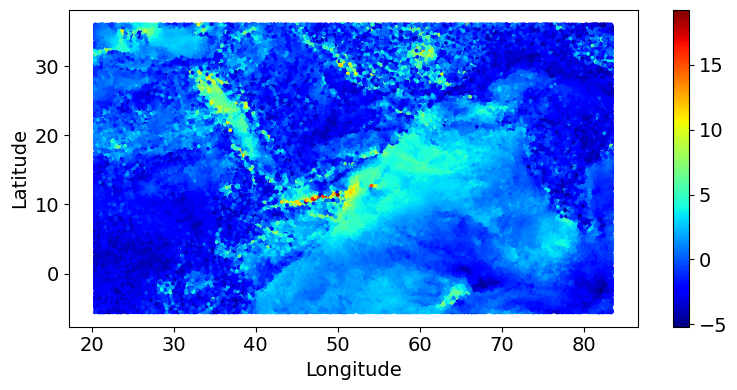

In [18]:
plot_subplots_with_scatter(
    './wind/meta_train_250000', 
    './wind/observation_train_250000',
    './wind/meta_test_250000', 
    './wind/observation_test_250000'   
)

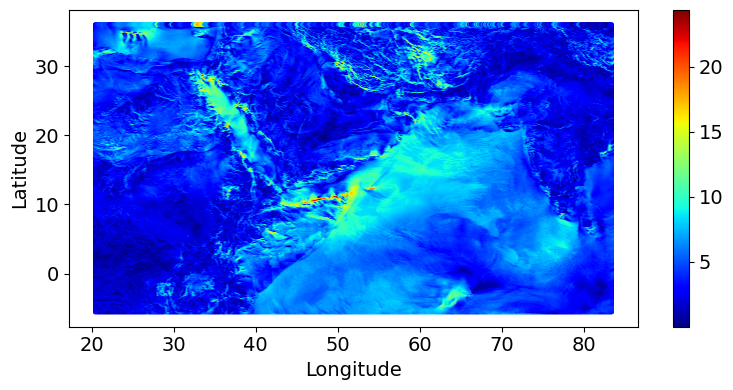

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_subplots_with_scatter(xx, yy, z):
    
    # Convert data to numpy arrays if they're not already
    xx = np.array(xx)
    yy = np.array(yy)
    z = np.array(z)
    
    # Create subplots
    fig, axs = plt.subplots(1, 1, figsize=(8, 4))
    
    # Scatter plot for training data
    scatter_train = axs.scatter(yy, xx, c=z, 
                            #  vmin=np.min(all_train_obs), vmax=np.max(all_train_obs), 
                             cmap="jet", s=3)
    # Create a colorbar
    cbar = fig.colorbar(scatter_train, ax=axs)
    cbar.ax.tick_params(labelsize =14)
    
    # axs.set_title('Training Data')
    axs.set_xlabel('Longitude', fontsize = 14)
    axs.set_ylabel('Latitude', fontsize = 14)
    
    # tick modification
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    plt.savefig('./fig/realdataset/wind_rawdata.jpeg', dpi=100)
    plt.show()

df_speed = pd.read_csv('./wind/20170901_speed_1038825.csv', header = None)
plot_subplots_with_scatter(df_speed.iloc[:, 0], df_speed.iloc[:, 1], df_speed.iloc[:, 2])

## Run the experiment with real dataset